## HW2. Классификация изображений
Автор: *Почтар Катрин Викторовна*, группа 2, 27 сентября 2025

In [1]:
import tensorflow as tf
print("TF:", tf.__version__)
print("Devices:", tf.config.list_physical_devices())
print("GPUs:", tf.config.list_physical_devices('GPU'))


TF: 2.16.2
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import time, tensorflow as tf
x = tf.random.normal([64, 224, 224, 3])
t0 = time.time(); _ = x + 1.0; print("Tensor add:", time.time()-t0)
t0 = time.time(); _ = tf.image.resize(x, (224,224)); print("Resize:", time.time()-t0)


Tensor add: 0.0003178119659423828
Resize: 0.005755186080932617


2025-09-28 20:00:05.990184: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-09-28 20:00:05.990212: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-09-28 20:00:05.990217: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-09-28 20:00:05.990236: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-09-28 20:00:05.990250: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [ ]:
import os
import sys
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from tensorflow.keras.applications import resnet, efficientnet
from tensorflow.keras.applications import ResNet50

SEED = 42
from tensorflow.keras.utils import to_categorical
np.random.seed(SEED); tf.random.set_seed(SEED)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [4]:
print("Python:", sys.version)
print("TensorFlow:", tf.__version__)
print("Keras:", getattr(keras, "__version__", "builtin in tf.keras"))

Python: 3.12.6 (v3.12.6:a4a2d2b0d85, Sep  6 2024, 16:08:03) [Clang 13.0.0 (clang-1300.0.29.30)]
TensorFlow: 2.16.2
Keras: 3.11.3


# Загрузка и обработка данных

In [5]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

In [6]:
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train,
    test_size=0.1,
    random_state=42,
    stratify=y_train,
)

In [ ]:
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)
y_test  = to_categorical(y_test,  num_classes)


print("Train:", x_train.shape, y_train.shape)
print("Validation:", x_val.shape, y_val.shape)
print("Test :", x_test.shape,  y_test.shape)

# Справочник классов
class_names = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

Train: (45000, 32, 32, 3) (45000, 10)
Validation: (5000, 32, 32, 3) (5000, 10)
Test : (10000, 32, 32, 3) (10000, 10)


In [8]:
print("Train:", x_train.shape, y_train.shape)
print("Validation:", x_val.shape, y_val.shape)
print("Test :", x_test.shape,  y_test.shape)

Train: (45000, 32, 32, 3) (45000, 10)
Validation: (5000, 32, 32, 3) (5000, 10)
Test : (10000, 32, 32, 3) (10000, 10)


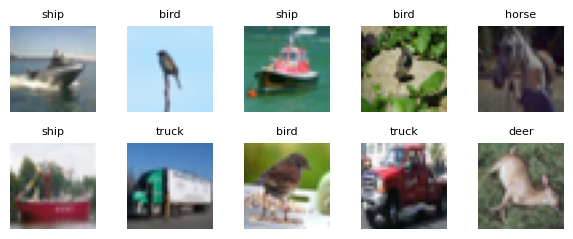

In [9]:
idx = np.random.choice(len(x_train), size=10, replace=False)
plt.figure(figsize=(6,6))
for i, j in enumerate(idx):
    plt.subplot(5,5,i+1)
    plt.imshow(x_train[j])
    plt.title(class_names[np.argmax(y_train[j])], fontsize=8)
    plt.axis("off")
plt.tight_layout()
plt.show()


## 1. Простая CNN


In [10]:
def eval_four_metrics(model, x_test, y_test, average="weighted"):
    
    y_proba = model.predict(x_test, verbose=0)

    # Convert to label vectors
    if y_proba.ndim > 1 and y_proba.shape[-1] > 1:
        y_pred = np.argmax(y_proba, axis=1)
        y_true = np.argmax(y_test, axis=1) if getattr(y_test, "ndim", 1) > 1 else y_test
    else:                                            # binary
        y_pred = (y_proba.ravel() >= 0.5).astype(int)
        y_true = y_test.ravel()

    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average=average, zero_division=0
    )
    return {
        "Accuracy": float(acc),
        "Precision": float(prec),
        "Recall": float(rec),
        "F1": float(f1),
    }

In [11]:
# Нормализация
x_train_cnn = x_train.astype("float32") / 255.0
x_val_cnn   = x_val.astype("float32") / 255.0
x_test_cnn  = x_test.astype("float32") / 255.0

In [12]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
], name="aug")

In [13]:
def plot_graphs(history):
    plt.figure(figsize=(6,4))
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.title('Accuracy'); plt.show()

    plt.figure(figsize=(6,4))
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.title('Loss'); plt.show()

In [14]:
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True, monitor="val_accuracy"),
    ReduceLROnPlateau(factor=0.5, patience=3, monitor="val_loss"),
    ModelCheckpoint("best_cnn.keras", save_best_only=True, monitor="val_accuracy")
]

In [15]:
def create_model_cnn():
    model = models.Sequential([
        
        layers.Conv2D(32, 3, activation='relu', padding="same", input_shape=(32,32,3)),
        layers.BatchNormalization(),
        layers.Conv2D(32, 3, activation='relu', padding="same"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),
        layers.Dropout(0.25),

        layers.Conv2D(64, 3, activation='relu', padding="same"),
        layers.BatchNormalization(),
        layers.Conv2D(64, 3, activation='relu', padding="same"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),
        layers.Dropout(0.25),

        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.25),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.25),
        layers.Dense(10, activation='softmax') ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [16]:
model_cnn = create_model_cnn()
model_cnn.summary()

/Users/katrindar/MIPT/Masters/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       262,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 330,954 (1.26 MB)

 Trainable params: 330,570 (1.26 MB)

 Non-trainable params: 384 (1.50 KB)

In [17]:
t0 = time.time()

history = model_cnn.fit(
    x=x_train_cnn,
    y=y_train,
    epochs=60,
    batch_size=128,
    validation_data=(x_val_cnn, y_val),
    callbacks=callbacks,
    verbose=2
)

train_min_cnn = (time.time() - t0) / 60
print(f"Training time (min): {train_min_cnn:.1f}")

Epoch 1/60


2025-09-28 20:00:08.730959: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


352/352 - 26s - 74ms/step - accuracy: 0.2234 - loss: 14.6284 - val_accuracy: 0.2112 - val_loss: 6.4251 - learning_rate: 0.0010
Epoch 2/60
352/352 - 22s - 63ms/step - accuracy: 0.3357 - loss: 5.7241 - val_accuracy: 0.5006 - val_loss: 1.7193 - learning_rate: 0.0010
Epoch 3/60
352/352 - 23s - 67ms/step - accuracy: 0.4159 - loss: 2.0445 - val_accuracy: 0.5286 - val_loss: 1.2558 - learning_rate: 0.0010
Epoch 4/60
352/352 - 24s - 69ms/step - accuracy: 0.4813 - loss: 1.4219 - val_accuracy: 0.5770 - val_loss: 1.1431 - learning_rate: 0.0010
Epoch 5/60
352/352 - 24s - 68ms/step - accuracy: 0.5290 - loss: 1.2905 - val_accuracy: 0.6106 - val_loss: 1.0602 - learning_rate: 0.0010
Epoch 6/60
352/352 - 26s - 73ms/step - accuracy: 0.5684 - loss: 1.1969 - val_accuracy: 0.6200 - val_loss: 1.0462 - learning_rate: 0.0010
Epoch 7/60
352/352 - 27s - 77ms/step - accuracy: 0.5893 - loss: 1.1416 - val_accuracy: 0.6400 - val_loss: 0.9992 - learning_rate: 0.0010
Epoch 8/60
352/352 - 27s - 78ms/step - accuracy: 0.

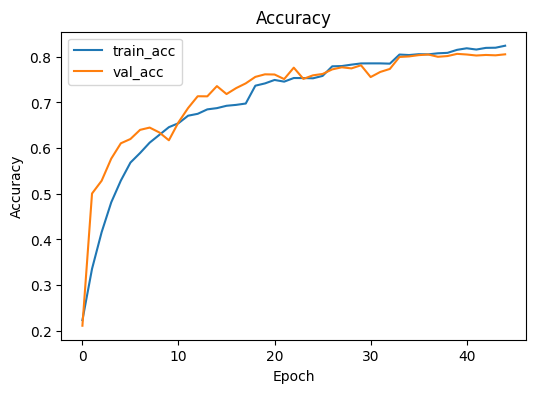

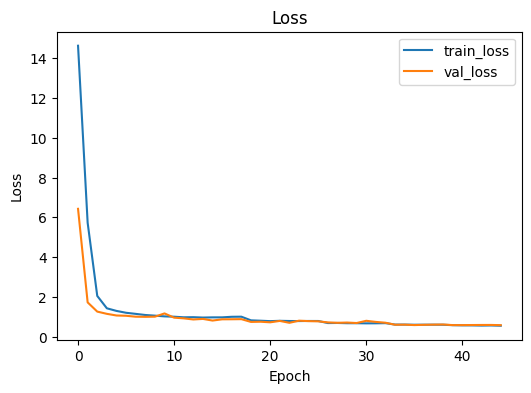

In [18]:
plot_graphs(history)

In [19]:
metrics_cnn = eval_four_metrics(model_cnn, x_test_cnn, y_test)
print(metrics_cnn)

{'Accuracy': 0.7984, 'Precision': 0.8005274861814913, 'Recall': 0.7984, 'F1': 0.7979652780451139}


In [ ]:
def plot_confmat(model, x, y_true, class_names, normalize=None):
    y_true_idx = y_true.squeeze() if y_true.ndim > 1 else y_true
    if y_true_idx.ndim > 1:
        y_true_idx = y_true_idx.argmax(axis=1)

    probs = model.predict(x, verbose=0)
    y_pred_idx = probs.argmax(axis=1)

    labels = np.arange(len(class_names))
    cm = confusion_matrix(y_true_idx, y_pred_idx, labels=labels, normalize=normalize)

    disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(5, 5))
    disp.plot(ax=ax, xticks_rotation=45, colorbar=False)
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    plt.tight_layout()
    plt.show()



# 2. Transfer Learning


In [21]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

In [22]:
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train,
    test_size=0.1,
    random_state=42,
    stratify=y_train,
)

In [23]:
IMG_SIZE   = 224
BATCH_SIZE = 32
NUM_CLASSES = 10 

In [24]:
def preprocess(image, label):
    image = tf.image.resize(tf.cast(image, tf.float32), (IMG_SIZE, IMG_SIZE))
    image = image / 255.0
    label = tf.squeeze(label, axis=-1)
    return image, label

In [25]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)) \
    .shuffle(len(x_train), seed=SEED) \
    .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE) \
    .batch(BATCH_SIZE) \
    .prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val)) \
    .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE) \
    .batch(BATCH_SIZE) \
    .prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)) \
    .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE) \
    .batch(BATCH_SIZE) \
    .prefetch(tf.data.AUTOTUNE)

In [26]:
base_resnet = ResNet50(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

base_resnet.trainable = False

In [27]:
model_resnet_frozen = models.Sequential([
    base_resnet,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation="softmax")
])

In [28]:
model_resnet_frozen.compile(optimizer=keras.optimizers.Adam(1e-3),
                            loss="sparse_categorical_crossentropy",
                            metrics=["accuracy"])

model_resnet_frozen.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,851,274 (90.99 MB)

 Trainable params: 263,562 (1.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [29]:
t0 = time.time()

hist_resnet_frozen = model_resnet_frozen.fit(
    train_ds, validation_data=val_ds, epochs=10, verbose=2
)

train_min_resnet = (time.time() - t0) / 60
print(f"Training time (min): {train_min_resnet:.1f}")

Epoch 1/10
1407/1407 - 702s - 499ms/step - accuracy: 0.1013 - loss: 2.5560 - val_accuracy: 0.1300 - val_loss: 2.3080
Epoch 2/10
1407/1407 - 714s - 507ms/step - accuracy: 0.1058 - loss: 2.3324 - val_accuracy: 0.1112 - val_loss: 2.3038
Epoch 3/10
1407/1407 - 748s - 532ms/step - accuracy: 0.1084 - loss: 2.3187 - val_accuracy: 0.1292 - val_loss: 2.3019
Epoch 4/10
1407/1407 - 748s - 532ms/step - accuracy: 0.1112 - loss: 2.3171 - val_accuracy: 0.1022 - val_loss: 2.2950
Epoch 5/10
1407/1407 - 730s - 519ms/step - accuracy: 0.1101 - loss: 2.3180 - val_accuracy: 0.1158 - val_loss: 2.2935
Epoch 6/10
1407/1407 - 713s - 506ms/step - accuracy: 0.1076 - loss: 2.3173 - val_accuracy: 0.1582 - val_loss: 2.2909
Epoch 7/10
1407/1407 - 755s - 537ms/step - accuracy: 0.1122 - loss: 2.3159 - val_accuracy: 0.1260 - val_loss: 2.2895
Epoch 8/10
1407/1407 - 719s - 511ms/step - accuracy: 0.1110 - loss: 2.3153 - val_accuracy: 0.1354 - val_loss: 2.2920
Epoch 9/10
1407/1407 - 711s - 505ms/step - accuracy: 0.1098 - lo

In [30]:
def eval_four_metrics_ds(model, ds, average="weighted"):
    y_true_parts = []
    for _, y in ds:
        y_true_parts.append(y.numpy())
    y_true = np.concatenate(y_true_parts, axis=0).ravel()

    y_proba = model.predict(ds, verbose=0)
    if y_proba.ndim > 1 and y_proba.shape[-1] > 1:
        y_pred = np.argmax(y_proba, axis=1)
    else:
        y_pred = (y_proba.ravel() >= 0.5).astype(int)

    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average=average, zero_division=0
    )
    return {"Accuracy": float(acc), "Precision": float(prec), "Recall": float(rec), "F1": float(f1)}

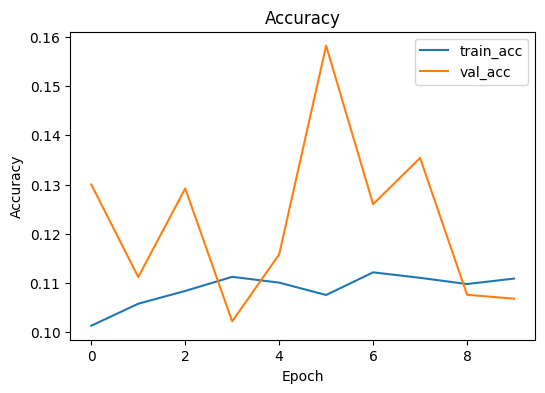

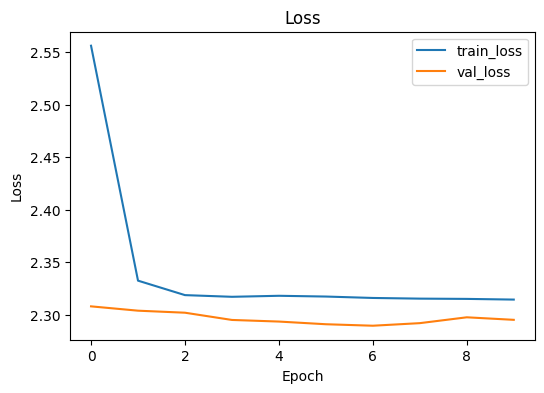

In [31]:
plot_graphs(hist_resnet_frozen)

In [32]:
metrics_resnet = eval_four_metrics_ds(model_resnet_frozen, test_ds)
print(metrics_resnet)

2025-09-28 22:19:47.112526: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'Accuracy': 0.1071, 'Precision': 0.033423376623376626, 'Recall': 0.1071, 'F1': 0.031176898395721922}


# 3. Vision Transformer

In [42]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

In [11]:
# randomly select 10 000 images
train_idx = np.random.choice(x_train.shape[0], 10000, replace=False)
x_train = x_train[train_idx]
y_train = y_train[train_idx]

# randomly select 1000 images
test_idx = np.random.choice(x_test.shape[0], 1000, replace=False)
x_test = x_test[test_idx]
y_test = y_test[test_idx]


In [12]:
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train,
    test_size=0.1,
    random_state=42,
    stratify=y_train,
)

In [14]:
IMG_SIZE = 224
BATCH_SIZE = 32

In [17]:
def plot_graphs(history):
    plt.figure(figsize=(6,4))
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.title('Accuracy'); plt.show()

    plt.figure(figsize=(6,4))
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.title('Loss'); plt.show()

In [18]:
def eval_four_metrics_ds(model, ds, average="weighted"):
    y_true_parts = []
    for _, y in ds:
        y_true_parts.append(y.numpy())
    y_true = np.concatenate(y_true_parts, axis=0).ravel()

    y_proba = model.predict(ds, verbose=0)
    if y_proba.ndim > 1 and y_proba.shape[-1] > 1:
        y_pred = np.argmax(y_proba, axis=1)
    else:
        y_pred = (y_proba.ravel() >= 0.5).astype(int)

    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average=average, zero_division=0
    )
    return {"Accuracy": float(acc), "Precision": float(prec), "Recall": float(rec), "F1": float(f1)}

In [19]:
import tensorflow_hub as hub

IMG_SIZE = 224
NUM_CLASSES = 10

# Загружаем backbone как функцию
vit_module = hub.load("https://tfhub.dev/sayakpaul/vit_b16_fe/1")

def vit_embedding(x):
    return vit_module(x)

In [20]:
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

x = layers.Lambda(vit_embedding)(inputs)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model_vit = keras.Model(inputs, outputs)

In [21]:
model_vit.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model_vit.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 99,722 (389.54 KB)

 Trainable params: 99,722 (389.54 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
t0 = time.time()

hist_vit = model_vit.fit(
    train_ds, validation_data=val_ds, epochs=10, verbose=2
)

train_min_vit = (time.time() - t0) / 60
print(f"Training time (min): {train_min_vit:.1f}")

Epoch 1/10
282/282 - 130s - 462ms/step - accuracy: 0.8688 - loss: 0.4518 - val_accuracy: 0.9620 - val_loss: 0.1004
Epoch 2/10
282/282 - 116s - 411ms/step - accuracy: 0.9517 - loss: 0.1486 - val_accuracy: 0.9660 - val_loss: 0.1058
Epoch 3/10
282/282 - 115s - 409ms/step - accuracy: 0.9643 - loss: 0.1111 - val_accuracy: 0.9720 - val_loss: 0.0828
Epoch 4/10
282/282 - 116s - 411ms/step - accuracy: 0.9719 - loss: 0.0852 - val_accuracy: 0.9740 - val_loss: 0.0894
Epoch 5/10
282/282 - 115s - 408ms/step - accuracy: 0.9732 - loss: 0.0763 - val_accuracy: 0.9700 - val_loss: 0.0889
Epoch 6/10
282/282 - 116s - 411ms/step - accuracy: 0.9772 - loss: 0.0653 - val_accuracy: 0.9690 - val_loss: 0.1038
Epoch 7/10
282/282 - 115s - 409ms/step - accuracy: 0.9802 - loss: 0.0561 - val_accuracy: 0.9730 - val_loss: 0.0929
Epoch 8/10
282/282 - 115s - 409ms/step - accuracy: 0.9818 - loss: 0.0514 - val_accuracy: 0.9750 - val_loss: 0.0978
Epoch 9/10
282/282 - 115s - 409ms/step - accuracy: 0.9843 - loss: 0.0446 - val_a

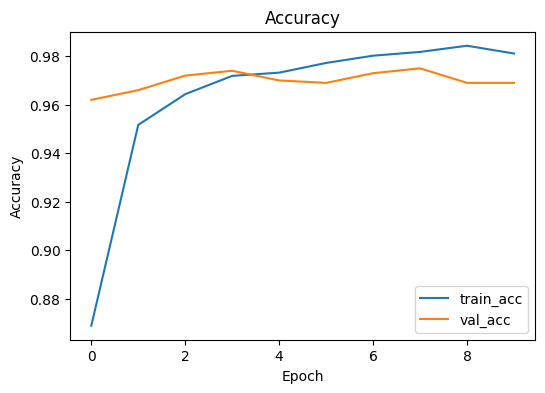

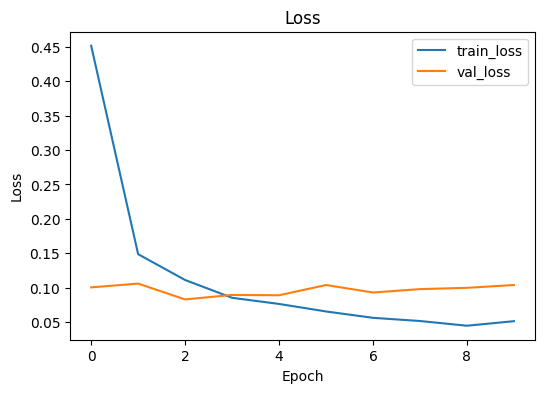

In [23]:
plot_graphs(hist_vit)

In [46]:
metrics_vit = eval_four_metrics_ds(model_vit, test_ds)
print(metrics_vit)

{'Accuracy': 0.9625, 'Precision': 0.9626741042734971, 'Recall': 0.9625, 'F1': 0.9624851569215774}


# 4. Сравнительный анализ

## 4.1 Метрики

In [ ]:
summary = pd.DataFrame([
    {"Model":"CNN", "Acc":metrics_cnn["Accuracy"], "Prec":metrics_cnn["Precision"],
     "Rec":metrics_cnn["Recall"], "F1":metrics_cnn["F1"], "Train(min)":train_min_cnn},
    {"Model":"Resnet_50", "Acc":metrics_resnet["Accuracy"], "Prec":metrics_resnet["Precision"],
     "Rec":metrics_resnet["Recall"], "F1":metrics_resnet["F1"], "Train(min)":train_min_resnet},
    {"Model":"ViT(fe)", "Acc":metrics_vit["Accuracy"], "Prec":metrics_vit["Precision"],
     "Rec":metrics_vit["Recall"], "F1":metrics_vit["F1"], "Train(min)":train_min_vit},
])

summary

,Model,Acc,Prec,Rec,F1,Train(min)
0,CNN,0.7984,0.800527,0.7984,0.797965,19.930668
1,Resnet_50,0.1071,0.033423,0.1071,0.031177,119.605278
2,ViT(fe),0.9625,0.962674,0.9625,0.962485,19.500000


## 4.2 Визуализация предсказаний

In [36]:
def show_preds(model, x_or_ds, y_true=None, class_names=None, count=10, seed=42):

    if isinstance(x_or_ds, tf.data.Dataset):
 
        samp = list(x_or_ds.unbatch().shuffle(10_000, seed=seed).take(count).as_numpy_iterator())
        X_batch = np.stack([im for im, lab in samp])
        y_batch = np.array([lab for im, lab in samp]).squeeze()
    else:
        n = len(x_or_ds)
        k = min(count, n)
        idx = np.random.choice(n, size=k, replace=False)
        X_batch = x_or_ds[idx]
        y_batch = None
        if y_true is not None:
            y_batch = y_true[idx]
            if y_batch.ndim > 1:
                y_batch = y_batch.argmax(axis=1)

    probs = model.predict(X_batch, verbose=0)
    preds = probs.argmax(axis=1)
    k = len(X_batch)

    def _to_rgb01(img):
        img = np.asarray(img)
        if img.max() > 1.5:      # [0,255] -> [0,1]
            img = img / 255.0
        elif img.min() < -0.1:   # [-1,1]  -> [0,1]
            img = (img + 1.0) / 2.0
        return np.clip(img, 0, 1)

    plt.figure(figsize=(12, 5))
    for i in range(k):
        plt.subplot(2, 5, i + 1)
        plt.imshow(_to_rgb01(X_batch[i]))
        title = f"pred: {class_names[preds[i]]} ({probs[i, preds[i]]:.2f})"
        if y_batch is not None:
            title += f"\ntrue: {class_names[int(y_batch[i])]}"
        plt.title(title, fontsize=9)
        plt.axis("off")
    plt.tight_layout(); plt.show()


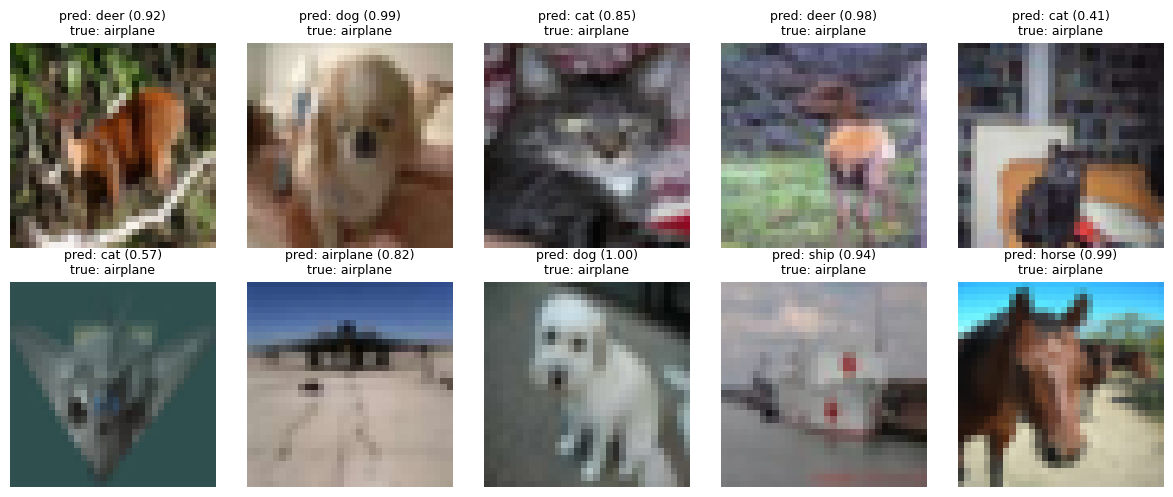

In [ ]:
# CNN
show_preds(model_cnn, x_test_cnn, y_test, class_names, count=10)

2025-09-28 23:21:33.307816: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


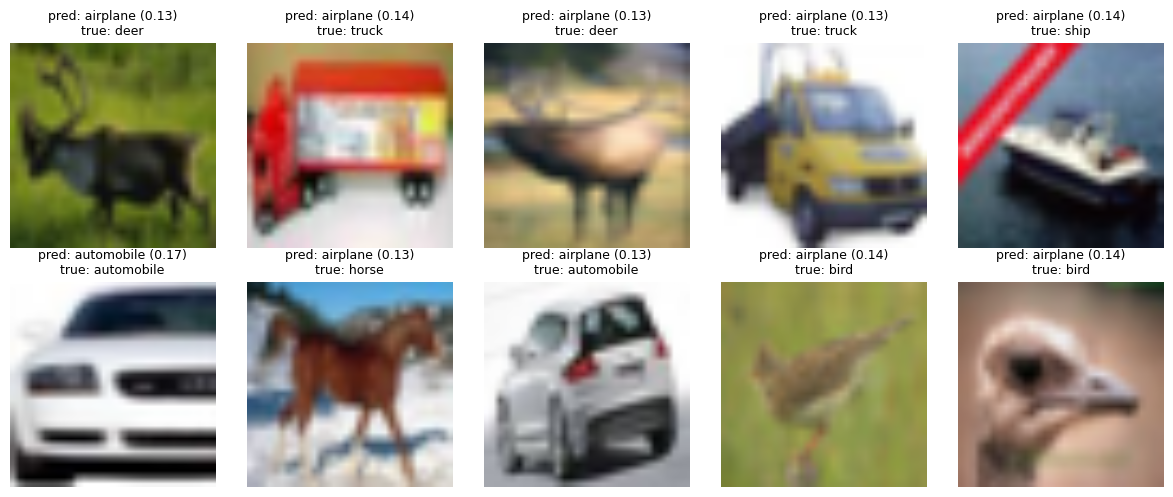

In [ ]:
# ResNet50 (frozen)

show_preds(model_resnet_frozen, test_ds, class_names=class_names, count=10)

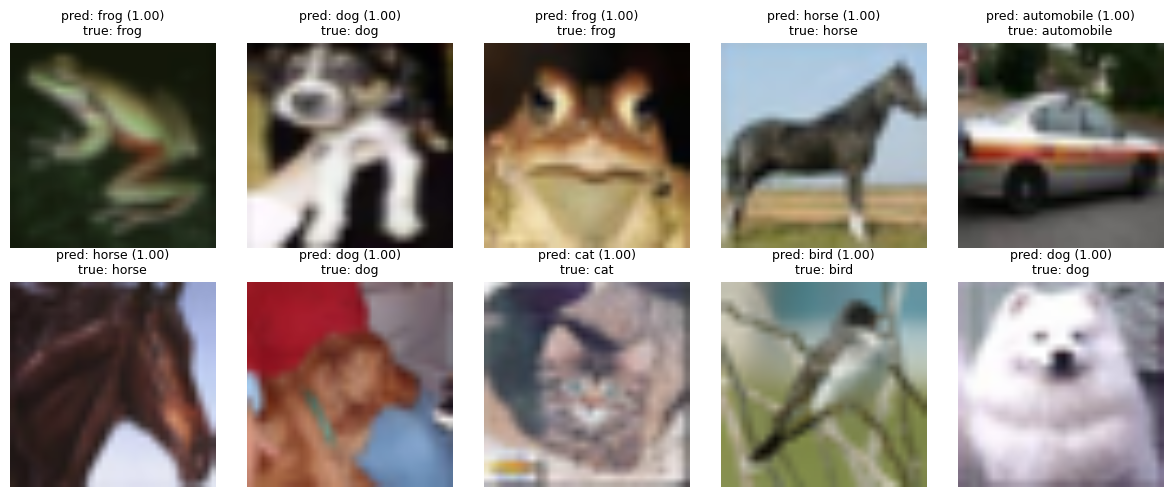

In [ ]:
# ViT (feature extractor)
show_preds(model_vit, test_ds, class_names=class_names, count=10)

## 4.3 Confusion matrix

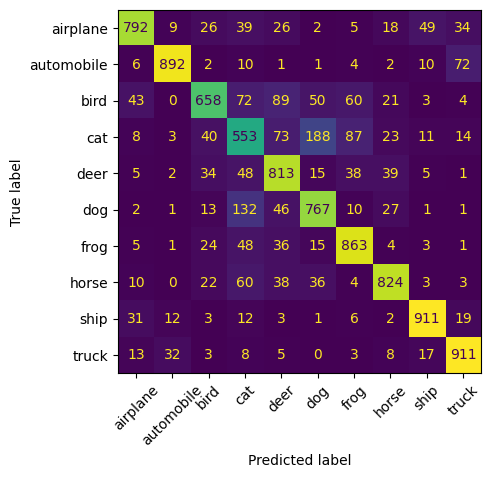

In [ ]:
# CNN
plot_confmat(model_cnn, x_test_cnn, y_test, class_names)

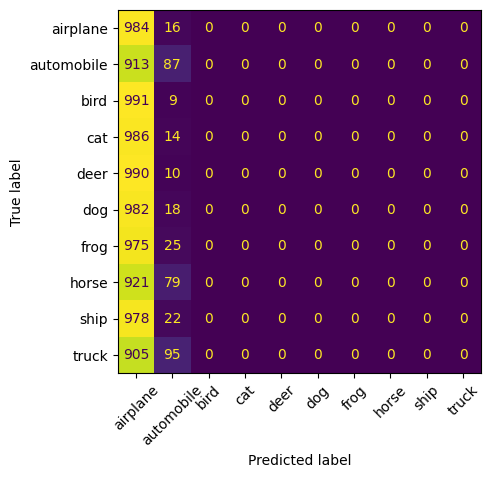

In [ ]:
# ResNet50 (frozen)
plot_confmat(model_resnet_frozen, test_ds, y_test, class_names)

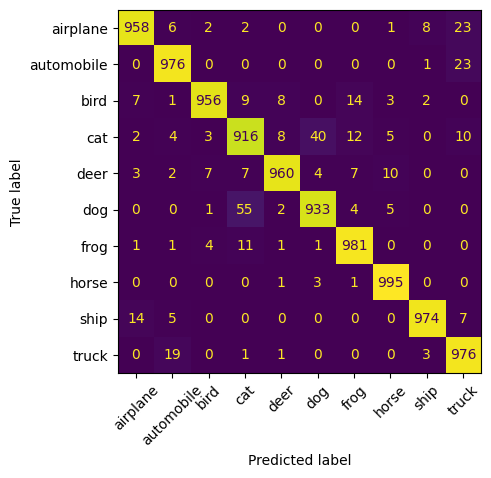

In [ ]:
# ViT (feature extractor)
plot_confmat(model_vit, test_ds, y_test, class_names)

# 5. Итоговый вывод

### Сравнение моделей:
* Точность: ViT ≫ CNN ≫ ResNet(замороженный)
* Скорость: ViT ≈ CNN (быстро), ResNet заметно медленнее. Но стоит отметить, что именно обучение для ViT было на sampled датасете, в отличии от остальных моделей. Поэтому скорее всего на всем датасете, ViT будет самым медленным.
* Практический смысл: с готовым сильным фиче-экстрактором (ViT из TF-Hub) задача CIFAR-10 решается лучше всего.

### Проблема:
* ResNet50 точность ~10% . Ошибка в предобрабоке данных, но пришлось бы перетренировывать модель. Судя по confusion matrix сейчас модель определяет практически все изображения к первому классу - самолеты.

## Когда что использовать:
* CNN (с нуля): когда датасет специфичен, небольшой, когда важна компактность модели.
* Transfer Learning (ResNet/EfficientNet): когда нужно быстро и стабильно получить высокий baseline на обычных изображениях; особенно если классы “похожи” на ImageNet. (Не забудь preprocess_input!)
* ViT (предобученный): когда нужна наивысшая точность, данные не очень уникальны. Простая модель в использовании, достаточно только добавить голову без fine-tuning.